In [1]:
%pylab inline
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


## 1

## 2

## 3 (a)

In [2]:
from networkie.gen.Custom import LoadFromFile
G = LoadFromFile().from_in_class_network('dataset/In-class_network.txt', directed=True)
isinstance(G, nx.DiGraph)

True

## 3 (b)

In [3]:
G = G.to_undirected()
print(nx.info(G))
components = [ G.subgraph(nodes) for nodes in nx.connected_components(G) ]
num_of_nodes = np.array([ g.order() for g in components ])
num_of_shortest_path = num_of_nodes*(num_of_nodes-1)
avg_shortest_path = np.array([nx.average_shortest_path_length(g)
                                    for g in components])
avg = (avg_shortest_path*num_of_shortest_path).sum()/num_of_shortest_path.sum()
print('Average path length:', avg)
print('Size of largest connected component:', max(num_of_nodes))

Name: 
Type: Graph
Number of nodes: 75
Number of edges: 109
Average degree:   2.9067
Average path length: 4.50847457627
Size of largest connected component: 45


## 3 (c)

In [4]:
emax = G.order()*(G.order()-1)//2
print('e / emax:', G.size()/emax)

e / emax: 0.03927927927927928


## 3 (d)

In [5]:
from networkie.utils import Measures
list_of_degree = Measures.Node(G).degree_dist()

<Container object of 10 artists>

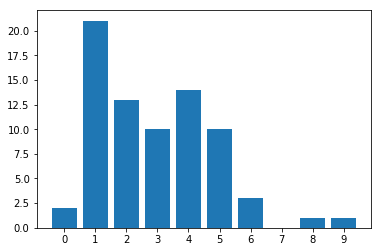

In [6]:
l = [0]*(1+max(list_of_degree))
for d in list_of_degree:
    l[d] += 1
plt.bar(range(len(l)), l, tick_label=range(len(l)))

## 3 (e)

In [7]:
Measures.compute_num_triangles(G)

52

## 6

In [19]:
import heapq
import random as rd

class Recommendation:

    def __init__(self, G, copy=True):
        self.g = G.copy() if copy else G
        self.potential = [set() for i in range(self.g.order())]
        self.update(range(self.g.order()))
    
    def update(self, node_list=None):
        if node_list is not None:
            for node in node_list:
                self.potential[node].clear()
                self.potential_firend(node)
        self.degree = np.array(Measures.Node(self.g).degree_dist())

    def potential_firend(self, someone):
        check = {someone} | set(self.g[someone])
        for friend in self.g[someone]:
            for friend_of_friend in self.g[friend]:
                if friend_of_friend in check:
                    continue
                self.potential[someone].add(friend_of_friend)
                check.add(friend_of_friend)
        return self.potential[someone]

    def friends_in_common(self, u, v):
        return len(set(self.g[u]) & set(self.g[v]))
    
    def importance(self, u, v):
        return self.degree[[u,v]].sum()

    def recommend(self, node, n):
        lis = [ ( -self.friends_in_common(ppl, node),
                  -self.importance(ppl, node), ppl )
                                  for ppl in self.potential[node] ]
        heapq.heapify(lis)
        for i in range(min(n, len(lis))):
            yield heapq.heappop(lis)[2]

    def remove_edge(self, ratio=0.05):
        edges = rd.sample(self.g.edges, round(self.g.size()*ratio) )
        self.g.remove_edges_from(edges)
        self.update(range(self.g.order()))
        return len(edges)
    
    def all_potential(self):
        for i, set_i in enumerate(self.potential):
            for n in set_i:
                if i < n:
                    yield (i, n)
    
    def add_recommend(self, n_run = 1):
        for i in range(n_run):
            edges = np.array(list(self.all_potential()))
            in_common = np.array([self.friends_in_common(*e) for e in edges])
            edges = edges[in_common == in_common.max()]
            importance = self.degree[edges].sum(1)
            edges = edges[importance == importance.max()]
            u, v = rd.choice(edges)
            self.g.add_edge(u, v)
            self.update(set(self.g[u]) | set(self.g[v]))


In [20]:
rec = Recommendation(G, copy=True)
print('Recommendation for student 45: ', *rec.recommend(45, 3) )
remove_n = rec.remove_edge(ratio=.05)
rec.add_recommend(n_run=remove_n)

Recommendation for student 45:  56 47 30


In [21]:
nx.symmetric_difference(rec.g, G).edges
# within 5 removed, 5 added back, most of them are different

EdgeView([(3, 17), (3, 63), (11, 47), (12, 51), (17, 63), (24, 71), (35, 67), (43, 48)])